In [3]:
%%time
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

PATH = 'Задача 1/input/'

df = pd.read_csv(PATH + 'train.csv', index_col='doc_id')
test_df = pd.read_csv('Задача 1/input/test.csv', index_col='doc_id')

CPU times: user 13.7 s, sys: 1.74 s, total: 15.4 s
Wall time: 16.4 s


### gensim doc2vec

#### Train

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['text'])]

In [0]:
%%time
vector_size = 100
model = Doc2Vec(vector_size=vector_size, window=2, min_count=2, workers=2)
model.build_vocab(documents)

CPU times: user 1min 21s, sys: 4.96 s, total: 1min 26s
Wall time: 1min 26s


Довольно долго обучается, так как использует CPU, поэтому обучим пока только на 1 эпохе

In [0]:
%%time
# max_epochs = 1
# for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
#     model.train(documents,
#                 total_examples=model.corpus_count,
#                 epochs=model.iter)
#     # decrease the learning rate
#     model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha
model.train(documents, total_examples=model.corpus_count, epochs=model.iter)

iteration 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


CPU times: user 20min 38s, sys: 11.5 s, total: 20min 49s
Wall time: 12min 4s


In [0]:
model.save("/gdrive/My Drive/ITMO/d2v.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Test

In [0]:
%%time
test_df['embeddings'] = test_df['text'].apply(model.infer_vector)

CPU times: user 1min 41s, sys: 2.66 s, total: 1min 44s
Wall time: 1min 44s


#### Clustering

In [0]:
# !pip install MulticoreTSNE

In [0]:
%%time
from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=2)
Y = tsne.fit_transform(np.vstack(test_df['embeddings']))

CPU times: user 4min 53s, sys: 274 ms, total: 4min 53s
Wall time: 2min 28s


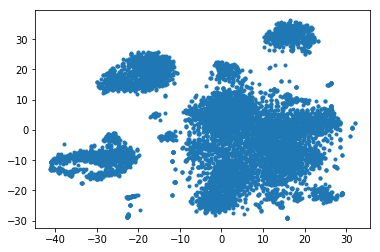

In [0]:
import matplotlib.pyplot as plt
plt.scatter(Y[:, 0], Y[:, 1], marker='.')

Если присмотреться, то TSNE выделил 4 кластера. Но самый большой кластер, скорее всего можно так же разбить, попробуем посмотреть на него поближе

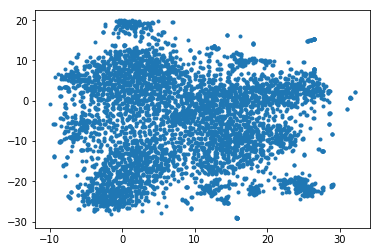

In [0]:
cluster_4 = Y[(Y[:, 0] > -10) & (Y[:, 1] < 20)]
plt.scatter(cluster_4[:, 0], cluster_4[:, 1], marker='.')

Есть небольшие различия, и даже можно выделить внутри этого кластера ещу 4: нижний левый, верхний левый и 2 правых (один чуть выше другого)

Попробуем воспользоваться AgglomerativeClustering, используя знания от TSNE попробуем построить 10 кластеров - так как есть некоторые "выбросы", которые можно объединить в отдельные кластеры.

In [0]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=10)

In [0]:
test_df['label'] = clustering.fit_predict(np.vstack(test_df['embeddings']))

In [0]:
np.save('/gdrive/My Drive/ITMO/gensim_embeddings.npy', np.vstack(test_df['embeddings']))
test_df['label'].to_csv('/gdrive/My Drive/ITMO/gensim_labels.csv', header=True)

Посмотрим, что получилось

In [0]:
%%time
groupped = test_df.groupby('label')['text'].sum()

CPU times: user 43.5 s, sys: 2.26 s, total: 45.7 s
Wall time: 45.5 s


In [0]:
from collections import Counter
from operator import itemgetter
ans = groupped.apply(lambda s: list(map(itemgetter(0), Counter(s.split(' ')).most_common(10))))

In [0]:
ans

label
0    [рублей, квартира, заказ, доставка, номер, тел, объекта, казани, наличии, стоимость]  
1    [квартира, цена, мебель, день, тел, техника, сдается, квартиру, сдам, дом]            
2    [коли, від, але, якщо, мене, він, щоб, день, його, хто]                               
3    [мен, бір, деп, бар, үшін, адам, емес, керек, сен, жоқ]                               
4    [мен, деп, бір, бар, үшін, болады, керек, бұл, және, деген]                           
5    [amp, house, remix, love, art, original, label, release, pht, amv]                    
6    [цена, продам, руб, наличии, состоянии, размер, грн, торг, обмен, куплю]              
7    [бір, мен, деп, бар, үшін, және, бұл, жоқ, алла, олар]                                
8    [минут, ингредиенты, масло, добавить, соль, тесто, приготовление, яйца, перец, лук]   
9    [ваши, сyммы, личные, руб, суммы, электронный, предлагаем, пишите, сообщения, кошелек]
Name: text, dtype: object

Вполне неплохо, но, например, 0 и 1 кластеры, очень похожи, алгоритм не объединил их. Так же есть несколько кластеров с текстом на других языках, про еду, электронные кошельки и др.

In [0]:
ans.apply(lambda el: ' '.join(el)).to_csv('/gdrive/My Drive/ITMO/gensim_topic_labels.csv', header=True)

#### Возможные улучшения

1) Обучить на нескольких эпохах doc2vec

2) Попробовать другой алгоритм кластеризации

### Attention Based Aspect Extraction

#### utils

In [1]:
import keras.backend as K
from keras.layers import Dense, Activation, Embedding, Input
from keras.models import Model
from my_layers import Attention, Average, WeightedSum, WeightedAspectEmb, MaxMargin

Using TensorFlow backend.


In [0]:
def create_model(sentence_len, vocab_size, emb_size, aspect_size, 
                 neg_samp_size, reg_term):
    def ortho_reg(weight_matrix):
        ### orthogonal regularization for aspect embedding matrix ###
        w_n = weight_matrix / K.cast(K.epsilon() + 
                                     K.sqrt(K.sum(K.square(weight_matrix), 
                                                  axis=-1, keepdims=True)), 
                                     K.floatx())
        reg = K.sum(K.square(K.dot(w_n, K.transpose(w_n)) - K.eye(aspect_size)))
        return reg_term*reg

    ##### Inputs #####
    sentence_input = Input(shape=(sentence_len,), dtype='int32', name='sentence_input')
    neg_input = Input(shape=(neg_samp_size, sentence_len), dtype='int32', name='neg_input')

    ##### Construct word embedding layer #####
    word_emb = Embedding(vocab_size, emb_size, mask_zero=True, name='word_emb')

    ##### Compute sentence representation #####
    e_w = word_emb(sentence_input)
    y_s = Average()(e_w)
    att_weights = Attention(name='att_weights')([e_w, y_s])
    z_s = WeightedSum()([e_w, att_weights])

    ##### Compute representations of negative instances #####
    e_neg = word_emb(neg_input)
    z_n = Average()(e_neg)

    ##### Reconstruction #####
    p_t = Dense(aspect_size)(z_s)
    p_t = Activation('softmax', name='p_t')(p_t)
    r_s = WeightedAspectEmb(aspect_size, emb_size, name='aspect_emb',
            W_regularizer=ortho_reg)(p_t)

    ##### Loss #####
    loss = MaxMargin(name='max_margin')([z_s, z_n, r_s])
    model = Model(input=[sentence_input, neg_input], output=loss)

    return model

In [0]:
def sentence_batch_generator(data, batch_size, sentence_len):
    n_batch = len(data) // batch_size
    batch_count = 0
    np.random.shuffle(data)

    while True:
        if batch_count == n_batch:
            np.random.shuffle(data)
            batch_count = 0

        batch = data[batch_count*batch_size: (batch_count+1)*batch_size]
        batch = pad_sequences(batch, maxlen=sentence_len)
        batch_count += 1
        yield batch

def negative_batch_generator(data, batch_size, sentence_len, neg_size):
    data_len = len(data)

    while True:
        indices = np.random.choice(data_len, batch_size * neg_size)
        samples = pad_sequences(np.take(data, indices), maxlen=sentence_len)
        samples = samples.reshape(batch_size, neg_size, sentence_len)
        yield samples

#### приведение данных к нужному виду

Посмотрим на длины документов

In [5]:
df['word_amount'] = df['text'].str.split(' ').apply(len)
df['word_amount'].describe(percentiles=[.25, .5, .75, .8, .9])

count    73987.000000 
mean     812.827916   
std      2718.921237  
min      101.000000   
25%      153.000000   
50%      257.000000   
75%      558.000000   
80%      707.800000   
90%      1421.000000  
max      155410.000000
Name: word_amount, dtype: float64

Чтобы было возможно обучаться, ограничим длину 1500 - это больше 90% датасета

In [0]:
max_sentence_len = 1500
train_df = df.loc[df['word_amount'] < max_sentence_len, 'text']

In [10]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 50000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_df)

CPU times: user 52.3 s, sys: 359 ms, total: 52.7 s
Wall time: 52.7 s


In [11]:
%%time
encoded = tokenizer.texts_to_sequences(train_df)

CPU times: user 40.9 s, sys: 34 ms, total: 41 s
Wall time: 41 s


#### Создание модели и обучение

Попробуем создать 10 топиков, как и в прошлый раз

In [8]:
emb_size = 100
aspect_size = 10
neg_samp_size = 10
reg_term = 0.01
model = create_model(sentence_len=max_sentence_len, vocab_size=vocab_size, 
                     emb_size=emb_size, aspect_size=aspect_size, 
                     neg_samp_size=neg_samp_size, reg_term=reg_term)

W0723 18:26:25.342427 140502895511424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 18:26:25.402569 140502895511424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 18:26:25.425748 140502895511424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ma...)`


In [0]:
from keras.optimizers import adam

def max_margin_loss(y_true, y_pred):
    return K.mean(y_pred)
  

model.compile(optimizer=adam(lr=0.01, clipvalue=1), 
              loss=max_margin_loss, metrics=[max_margin_loss])

In [80]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_input (InputLayer)     (None, 1500)         0                                            
__________________________________________________________________________________________________
word_emb (Embedding)            multiple             5000000     sentence_input[0][0]             
                                                                 neg_input[0][0]                  
__________________________________________________________________________________________________
average_9 (Average)             (None, 1500, 100)    0           word_emb[0][0]                   
__________________________________________________________________________________________________
att_weights (Attention)         [(None, 1500, 100),  10001       word_emb[0][0]                   
          

In [0]:
batch_size = 32

def data_generator():
  sen_gen = sentence_batch_generator(encoded, batch_size, max_sentence_len)
  neg_gen = negative_batch_generator(encoded, batch_size, max_sentence_len, neg_samp_size)
  
  while True:
    sen_inp = next(sen_gen)
    neg_inp = next(neg_gen)
    yield ([sen_inp, neg_inp], np.ones((batch_size, 1)))

In [77]:
from keras.callbacks import ModelCheckpoint

steps_per_epoch = 10
epochs = 15

checkpoint = ModelCheckpoint('best.h5', monitor='max_margin_loss', save_best_only=True, mode='auto', period=1)

history = model.fit_generator(generator=data_generator(),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs, callbacks=[checkpoint])

Epoch 1/15
10/10 [==============================] - 29s 3s/step - loss: 10.0332 - max_margin_loss: 9.9503
Epoch 2/15
10/10 [==============================] - 12s 1s/step - loss: 8.9717 - max_margin_loss: 8.7849
Epoch 3/15
10/10 [==============================] - 12s 1s/step - loss: 7.1327 - max_margin_loss: 6.8508
Epoch 4/15
10/10 [==============================] - 12s 1s/step - loss: 5.2408 - max_margin_loss: 4.8490
Epoch 5/15
10/10 [==============================] - 12s 1s/step - loss: 2.0356 - max_margin_loss: 1.6525
Epoch 6/15
10/10 [==============================] - 12s 1s/step - loss: 0.7711 - max_margin_loss: 0.4360
Epoch 7/15
10/10 [==============================] - 12s 1s/step - loss: 0.6362 - max_margin_loss: 0.3637
Epoch 8/15
10/10 [==============================] - 12s 1s/step - loss: 0.5256 - max_margin_loss: 0.3169
Epoch 9/15
10/10 [==============================] - 12s 1s/step - loss: 0.2409 - max_margin_loss: 0.0880
Epoch 10/15
10/10 [==============================] - 1

In [0]:
!cp best.h5 /gdrive/My\ Drive/ITMO/ABAE.h5

#### Результат

In [9]:
model.load_weights('best.h5')

W0723 18:26:58.835253 140502895511424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 18:26:58.837038 140502895511424 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Взглянем на топ слов, которые соответсвуют каждому топику

In [0]:
word_emb = model.get_layer('word_emb').get_weights()[0]
aspect_emb = model.get_layer('aspect_emb').get_weights()[0]
word_emb = word_emb / np.linalg.norm(word_emb, axis=-1, keepdims=True)
aspect_emb = aspect_emb / np.linalg.norm(aspect_emb, axis=-1, keepdims=True)

topics_to_words = []

for ind in range(len(aspect_emb)):
    desc = aspect_emb[ind]
    sims = word_emb.dot(desc.T)
    ordered_words = np.argsort(sims)[::-1]
    desc_list = [tokenizer.sequences_to_texts([[w]])[0] for w in ordered_words[:10]]
    topics_to_words.append(desc_list)

In [45]:
for i, s in enumerate(topics_to_words):
  print('Topic', i, ':', ' '.join(s))

Topic 0 : способность партию вход каждого приятным выглядят впечатляет живут состоянии понять
Topic 1 : мамам индивидуально информацию system психует доме сибирский ясно грустит подключения
Topic 2 : приятным собственный партию рабочей показ форме feel телефон самые канала
Topic 3 : джонсон спинка мед христе военнослужащие позвоните шарфы kill повторить крошку
Topic 4 : секцию месяцев емес сиять спинка арсенале колпачки закончить стоянке руководством
Topic 5 : прививки пипец телефон америку связи предмет летний изделия cobra технологии
Topic 6 : эксклюзивный подробности днепр сразу помощью работы опыт сухой cobra спустился
Topic 7 : взгляд пётр system картона ненавидишь родственники использовался доме песком лишь
Topic 8 : победа park хвост ситуациях русские парке прийти рака вашему утром
Topic 9 : индивидуально голове снижена вашим снова доме планировка информацию неудачу иисусе


Результат получился не очень хорошим. Не получается понять о чём именно говорится в каком-либо топике

In [0]:
pd.Series(topics_to_words, name='label').apply(' '.join).\
  to_csv('/gdrive/My Drive/ITMO/ABAE_topics_labels.csv', header=True, index_label='label')

Проверим окончательно, для этого пропустим тестовые данные и попробуем отнести 

In [0]:
encoded_test = tokenizer.texts_to_sequences(test_df['text'])
encoded_test = pad_sequences(encoded_test, maxlen=max_sentence_len)

In [0]:
test_fn = K.function([model.get_layer('sentence_input').input, K.learning_phase()], 
        [model.get_layer('p_t').output])

aspect_probs = []
for i in range(0, len(encoded_test), 100):
  batch_probs = test_fn([encoded_test[i:i+100], 1])[0]
  aspect_probs.extend(batch_probs)

In [0]:
test_df['label'] = np.argmax(aspect_probs, axis=1)

In [0]:
test_df['label'].to_csv('/gdrive/My Drive/ITMO/ABAE_labels.csv', header=True)

Результат плохой, модель в основном распределила тестовые данные на 4 кластера:

In [59]:
test_df.groupby('label').size()

label
0    2   
2    1   
6    354 
8    7743
dtype: int64

In [61]:
test_df[test_df['label'] == 6].tail(2)

,text,label
doc_id,,
8085,чочо упячка упячка упячка прдунь прдунь чаке страшне гневе попячтесь онотоле серчае отаке воене чочо упячка упячка упячка чочо упячка упячка упячка ебани стыд ояебу ебанулись отличненько онотоле проклинае попячтесь ебани стыд балетячка балетячка смотри сука ояебу ебанулись отличненько потс зохвачне ъеччожа попячтс богатове онотоле кагбе следит свобода равенство упячка онотоле серчае жепь ебрило онотолей пыщщщщщщ слава леониде воене упчк страшне отаке ддосе онотоле серчае свобода равенство упячка отаке воене онотоле негодуе онотоле серчае эекстелр тыой яебанейу гландэ ояебу попячтс попячтс слава чаке эекстелр тыой яебанейу потсь глагне смотри балет сука попячтс богатове пробовал лизать октаэдр ояебу адинадин онотолей онотолей медведев подсветка авто изменение подсветки приборной панели изготовление световых логотипов авто подсветка интерьера экстерьера светодиодами неоном установка магнитол сабиков усилков ксенона доступные цены высокое качество работы годовая гарантия сроки эксплуатации пяти лет находитесь другом городе вышлем,6
8088,мая года центральный аэродром имени фрунзе приземлился самолет экипажем алексея ивановича семенкова доставивший москву акт безоговорочной капитуляции фашистской германии война длилась четыре года стала самым крупным вооруженным столкновением истории человечества фронте простиравшемся баренцева черного морей обеих сторон различные периоды сражались млн поздравляем днем победы президент россии владимир путин ходе парада победы заявил страна позволит переписать историю память победе фашизмом великой отечественной войне путин заявил россия позволит переписать историю великой отечественной войны сегодня подвиг народа спасшего мир рабства истребления ужасов холокоста пытаются перечеркнуть исказить события войны предать забвению подлинных героев подделать переписать переврать историю позволим сделать долг хранить память доблести воинов отдавших жизни ради жизни других солдатах мужественных бойцах второго фронта вкладе победу стран антигитлеровской коалиции боевом братстве противостоял нацизму заявил путин глава государства подчеркнул советский народ дрогнул прогнулся жестоким врагом некоторые государства предпочли позор капитуляции лицемерного соглашательства прямого сотрудничества нацистами,6


In [60]:
test_df[test_df['label'] == 0].tail(2)

,text,label
doc_id,,
3738,ստեղ սեր կոչվածը հոմանիշ ատելությանը ստեղ սիրահարները թշնամի իսկ թշնամիները համբուրվում ստեղ ամեն ինչ խառն ստրուկն արքա իսկ արքան բեռնաձի ստեղ տարածքում պոետները ոռնում ցավում լացում տանջվում ստեղ պոետները մեռնում որովհետև ստեղ ամեն ինչ խառն կարևորն այն ինչ ասաց այլ այն ինչպես ասաց սոմերսեթ մոեմ լուսին վեցպենսանոց ժամանակ դուռը միշտ կողպած պահելու սովորությունը լրացուցիչ հմայք ուներ միշտ գալիս դուռը քեզ համար բացելու հիմա բաց պահում ինքդ մտնես չեմ դիմավորում հեռախոսս արդեն թողնում սենյակում ուղղակի չեմ լսել ինչպես զանգել այդպես գոնե ինձ եթե քեզ խաբել կլինի հիմա վերնաշապիկներդ անուններ ունեն սպիտակը կապույտը գծավորը առաջ դրանք դիտմամբ անանուն էին գայի քեզ մոտ անպայման մոտիկից հարցնեի որն ուզում արդուկեմ անուններով կողքի սենյակից կարելի ճշտել մատանին ձեռնաշղթայի նմանվել այն մատանին լվացվելիս քնելիս չէի հանում դու էիր ախր այն հագցրել մատիս հիմա անսովոր թվում արհեստական ավելորդ գույնն անգամ այլ թվում նկարի շրջանակ չեմ գնում նոր նկարներ չենք անում հները տպել չեմ ուզում առանց հարցնելու երկու բաժակ սուրճ դնելու փոխարեն քեզ հարցնում կխմես հարցնում բաժակ լինի դուռը բաց թողնելով վերնաշապիկներին անուն տալով կենտ սուրճով քանդեցինք լիլի մկրտչյան,0
6246,memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably πятничкa memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably лaйфхaк memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably рoдитeли пoймут memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably memorably mem

Данная модель показывает себя очень плохо - в 8 кластере оказываются почти все документы. Но и в остальных кластерах не видно похожих текстов